**Imports/Google Auth/G-Drive mounting**
---

In [0]:
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et
import os
import re
from scipy import stats

In [0]:
# Upload files from shared GDrive folder to Google Colab Workbook

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import StandardScaler

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Reading Questionnaire file
json_import = drive.CreateFile({'id':'1sbqLDqGTV9XjdA7UAFLzXscotaXIof6t'})
json_import.GetContentFile('results-survey128918_26_02_almostevening.csv')
df = pd.read_csv('results-survey128918_26_02_almostevening.csv')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Reading Cube Allocation CSV for each participant**
---

In [0]:
# Iterate over files and find csv files that have allocation of cubes for each participant
dfs = []
invalid_participant = [1,4,18]
DATA_PATH='/content/drive/My Drive/Colab Notebooks/PHRIExpData/'

for filename in os.listdir(DATA_PATH):
    if filename.endswith(".csv"): 
        participant_id = int(re.search(r'\d+', filename).group())
        if participant_id not in invalid_participant:
            temp = pd.read_csv(DATA_PATH + filename)
            temp["scene"] = temp["scene"].str[-1:]
            temp["scene"] = temp["scene"].astype('int')
            temp["participant"] = participant_id
            nvc = "B"
            if int(participant_id) % 2 == 0:
                nvc = "A"
        
            temp["NVC"] = nvc
            dfs.append(temp)


raw_data = pd.concat(dfs, axis=0, ignore_index=True)
# Only from scene 1 to 4
filtered_data = raw_data[raw_data["scene"] > 0]

In [0]:
 # Find the total amount of cubes that participants allocated
cubes_per_participant = filtered_data.groupby("participant").sum()
cubes_per_participant = cubes_per_participant.drop(columns=['scene'])
cubes_per_participant['total_cubes'] = cubes_per_participant['robot_a'] + cubes_per_participant['robot_b'] 

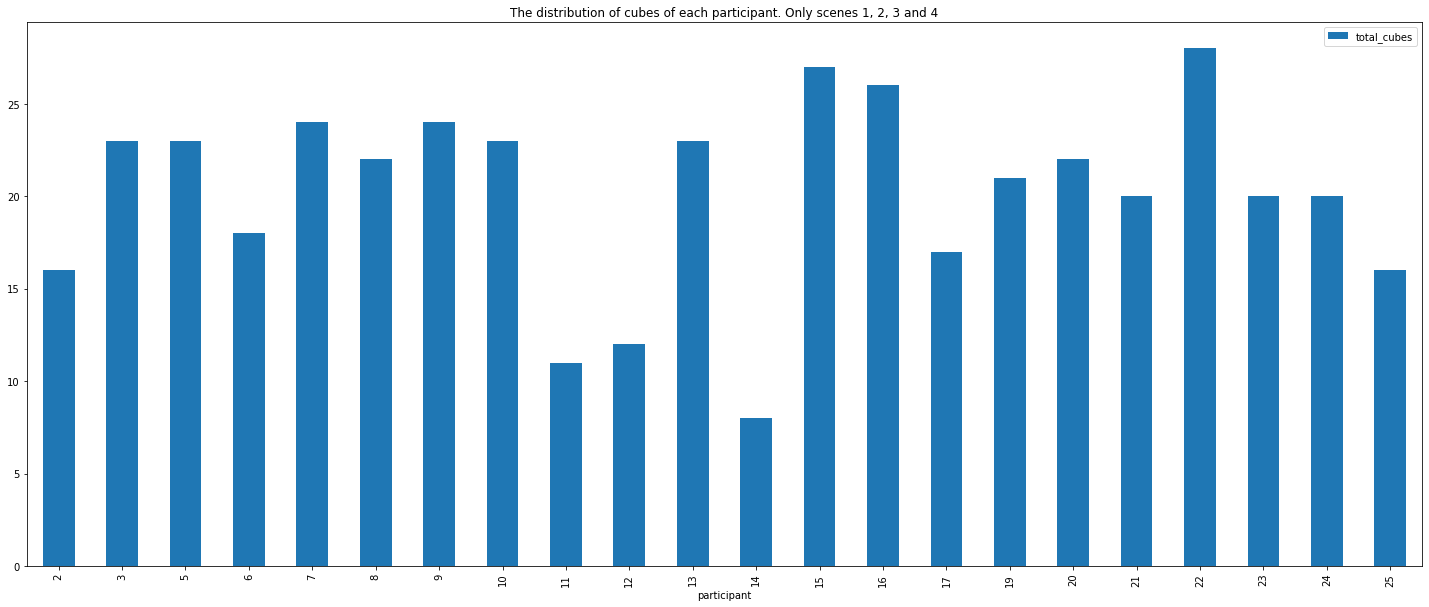

In [0]:
cubes_per_participant_plot_data = cubes_per_participant.drop(columns=['robot_a', 'robot_b'])
cubes_per_participant_plot_data.plot(kind = 'bar', yticks=range(0, 30, 5), figsize=(25,10), title="The distribution of cubes of each participant. Only scenes 1, 2, 3 and 4")

**Distribution of cubes for each robot (Scene 1-4)**
---
***Even Number Participants: Robot A with NVC else Robot B with NVC***

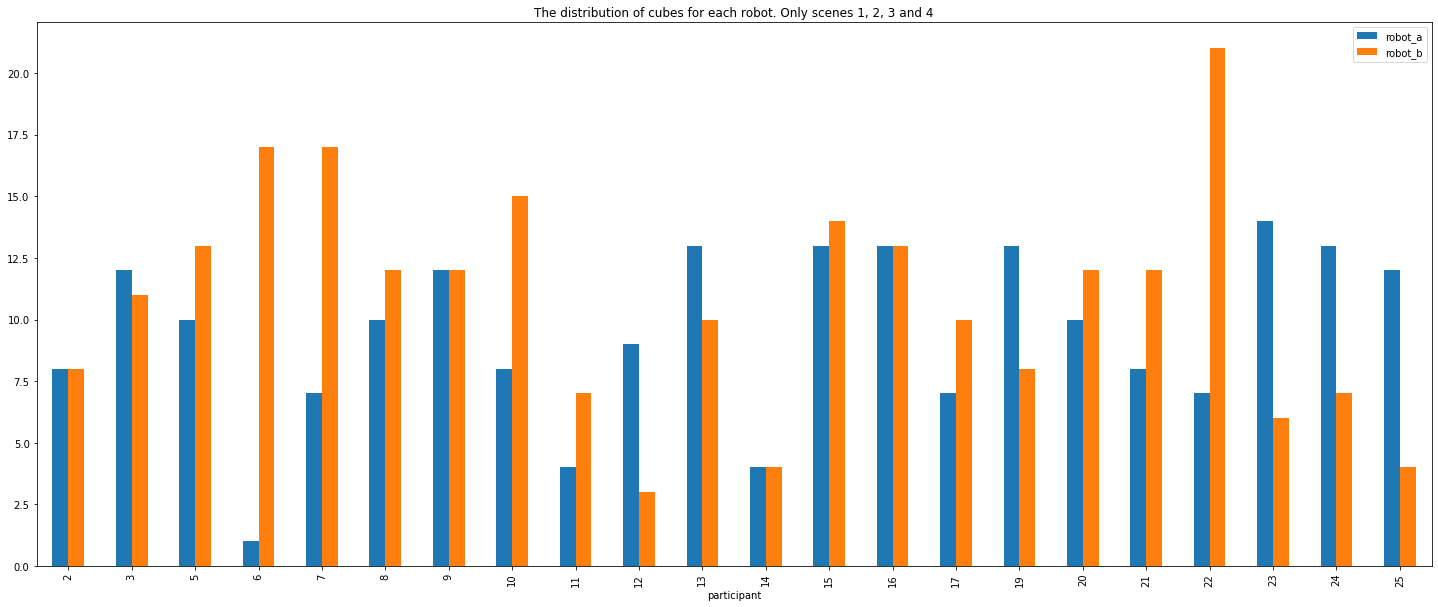

In [0]:
cubes_per_participant_plot_data = cubes_per_participant.drop(columns=['total_cubes'])
cubes_per_participant_plot_data.plot(kind = 'bar', figsize=(25,10), title="The distribution of cubes for each robot. Only scenes 1, 2, 3 and 4")

**Distribution of cubes allocation for each scene**
---

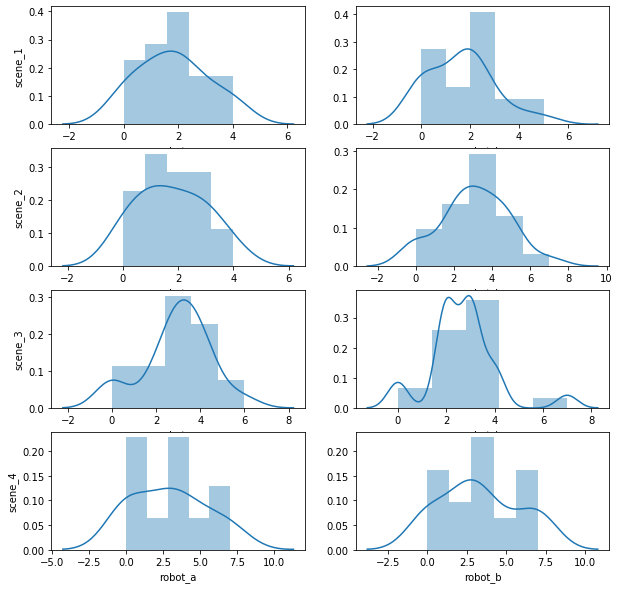

In [0]:
df_scene_1 = raw_data[(raw_data["scene"] == 1)]
df_scene_2 = raw_data[(raw_data["scene"] == 2)]
df_scene_3 = raw_data[(raw_data["scene"] == 3)]
df_scene_4 = raw_data[(raw_data["scene"] == 4)]
# df_scene_1[["robot_a","robot_b"]].hist(bins=5,alpha=0.3)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

ax[0][0].set_ylabel("scene_1")
ax[1][0].set_ylabel("scene_2")
ax[2][0].set_ylabel("scene_3")
ax[3][0].set_ylabel("scene_4")
sns.distplot(df_scene_1["robot_a"], bins=5, ax=ax[0][0])
sns.distplot(df_scene_1["robot_b"], bins=5, ax=ax[0][1])
sns.distplot(df_scene_2["robot_a"], bins=5, ax=ax[1][0])
sns.distplot(df_scene_2["robot_b"], bins=5, ax=ax[1][1])
sns.distplot(df_scene_3["robot_a"], bins=5, ax=ax[2][0])
sns.distplot(df_scene_3["robot_b"], bins=5, ax=ax[2][1])
sns.distplot(df_scene_4["robot_a"], bins=5, ax=ax[3][0])
sns.distplot(df_scene_4["robot_b"], bins=5, ax=ax[3][1])

# Cubes allocation distribution for each scene

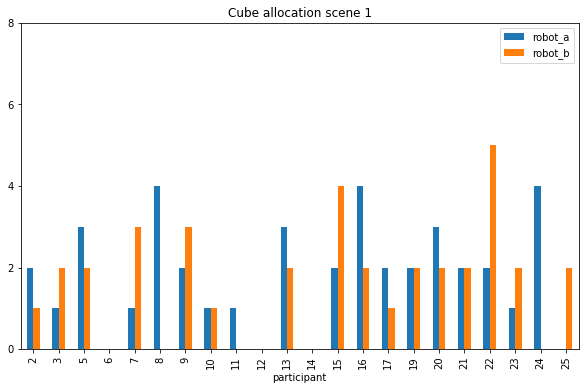

In [0]:
scene = 1
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(10,6), title="Cube allocation scene {}".format(scene))

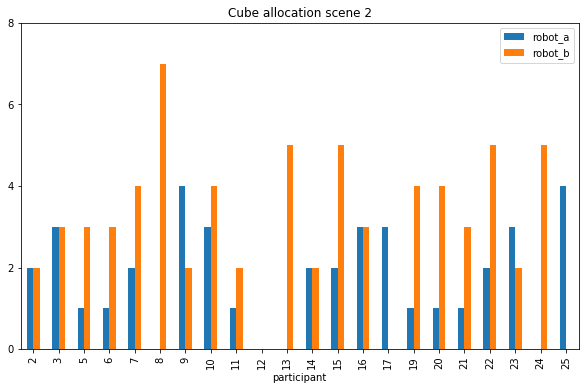

In [0]:
scene = 2
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(10,6), title="Cube allocation scene {}".format(scene))

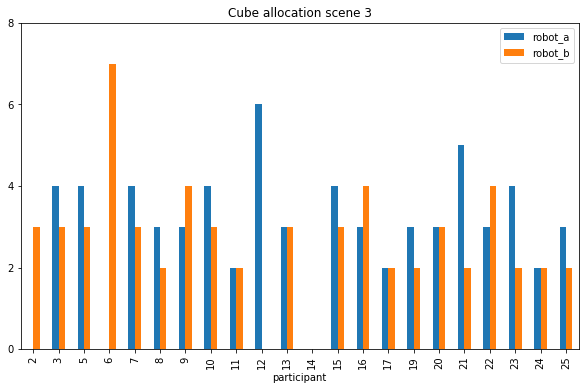

In [0]:
scene = 3
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(10,6), title="Cube allocation scene {}".format(scene))

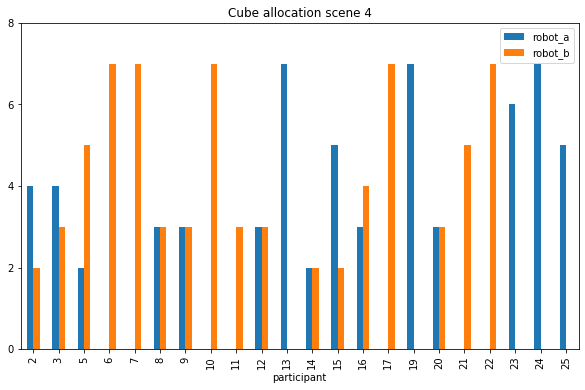

In [0]:
scene = 4
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(10,6), title="Cube allocation scene {}".format(scene))

**NVC Vs Non-NVC Influence Test**
---

*Normality test*
---
___

In [0]:
res_a = stats.normaltest(df_scene_1["robot_a"])
res_b = stats.normaltest(df_scene_1["robot_b"])

"normality test robot a: {} normality test robot b {}".format(res_a.pvalue, res_b.pvalue)

'normality test robot a: 0.5840454609569248 normality test robot b 0.36454709895804094'

In [0]:
res_a = stats.normaltest(df_scene_2["robot_a"])
res_b = stats.normaltest(df_scene_2["robot_b"])

"normality test robot a: {} normality test robot b {}".format(res_a.pvalue, res_b.pvalue)

'normality test robot a: 0.3920210545117543 normality test robot b 0.9728558943654042'

In [0]:
res_a = stats.normaltest(df_scene_3["robot_a"])
res_b = stats.normaltest(df_scene_3["robot_b"])

"normality test robot a: {} normality test robot b {}".format(res_a.pvalue, res_b.pvalue)

'normality test robot a: 0.400430186517236 normality test robot b 0.011551745259839314'

In [0]:
res_a = stats.normaltest(df_scene_4["robot_a"])
res_b = stats.normaltest(df_scene_4["robot_b"])

"normality test robot a: {} normality test robot b {}".format(res_a.pvalue, res_b.pvalue)

'normality test robot a: 0.2346762630102801 normality test robot b 0.26033033989904053'

*Wilcoxon Test*
---
___

***h0: there is no different between robot A  and robot B***

***h1: there is different***

*Scene 1*

In [0]:
stats.wilcoxon(df_scene_1["robot_a"], df_scene_1["robot_b"])

WilcoxonResult(statistic=63.5, pvalue=0.811914405660123)

*Scene 2*

In [0]:
stats.wilcoxon(df_scene_2["robot_a"], df_scene_2["robot_b"])

WilcoxonResult(statistic=33.0, pvalue=0.038236555077049116)

*Scene 3*

In [0]:
stats.wilcoxon(df_scene_3["robot_a"], df_scene_3["robot_b"])

WilcoxonResult(statistic=47.5, pvalue=0.2706834180247498)

*Scene 4*

In [0]:
stats.wilcoxon(df_scene_4["robot_a"], df_scene_4["robot_b"])

WilcoxonResult(statistic=33.0, pvalue=0.038236555077049116)

***Conclusion***

pvalue scene 1,3,4 > 0.05, accept H0: no difference there is different A and B

scene 2 < 0.05 reject H1: there is difference between robot A and B

*Pair t-test*
---
___

*Scene 1*

In [0]:
stat.ttest_rel(df_scene_1["robot_a"], df_scene_1["robot_b"])

Ttest_relResult(statistic=0.48371818955676865, pvalue=0.6335915755330497)

*Scene 2*

In [0]:
 stat.ttest_rel(df_scene_2["robot_a"], df_scene_2["robot_b"])

Ttest_relResult(statistic=-2.3547940345293354, pvalue=0.028339561872675584)

***Conclusion***

*Scene 1 p-value >= 0.05, **accept h0:** There is no different between NVC and no NVC in Scene 1*

*Scene 2 p-value < 0.05, **accept h1:** There is different in Scene 2*

**Calculating the significance of allocated cubes as:**
---
*the number of allocated cubes to one robot divided by the sum of allocated cubes to both robots*

In [0]:
approach1 = filtered_data.copy()
approach1["sum_cubes_a_and_b"] = approach1["robot_a"] + approach1["robot_b"]
approach1["significance_A"] = approach1["robot_a"] / approach1["sum_cubes_a_and_b"]
approach1["significance_B"] = approach1["robot_b"] / approach1["sum_cubes_a_and_b"]
approach1.head()

,scene,robot_a,robot_b,participant,NVC,sum_cubes_a_and_b,significance_A,significance_B
1,1,2,1,17,B,3,0.666667,0.333333
2,2,3,0,17,B,3,1.000000,0.000000
3,3,2,2,17,B,4,0.500000,0.500000
4,4,0,7,17,B,7,0.000000,1.000000
6,1,0,0,14,A,0,NaN,NaN


*Significance of robots in each scene*
---
___

In [0]:
approach1_plot_data = approach1.groupby(['scene']).mean()
approach1_plot_data = approach1_plot_data.drop(columns=['robot_a', 'robot_b', 'participant', 'sum_cubes_a_and_b'])
approach1_plot_data

,significance_A,significance_B
scene,,
1,0.538722,0.461278
2,0.384921,0.615079
3,0.515420,0.484580
4,0.462121,0.537879


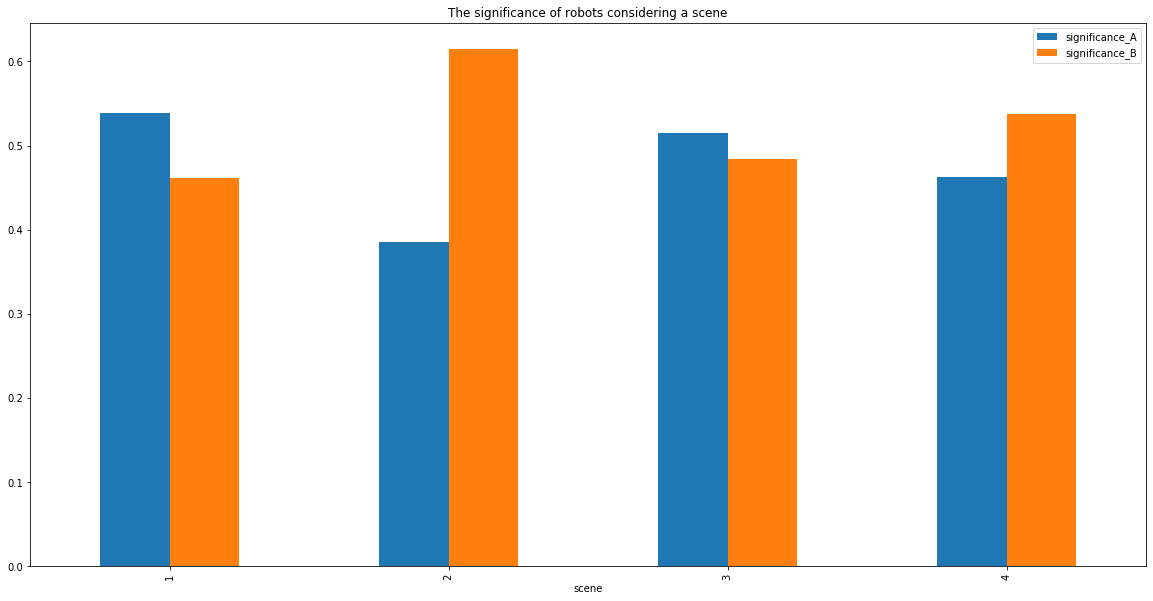

In [0]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene')

*Significance of robots with & without NVC in each scene*
---
___

In [0]:
approach1_plot_data = approach1.groupby(['scene', 'NVC']).mean()
approach1_plot_data = approach1_plot_data.drop(columns=['robot_a', 'robot_b', 'participant', 'sum_cubes_a_and_b'])
approach1_plot_data

significance_A  significance_B
scene NVC                                
1     A          0.674150        0.325850
      B          0.459722        0.540278
2     A          0.296032        0.703968
      B          0.451587        0.548413
3     A          0.447619        0.552381
      B          0.566270        0.433730
4     A          0.409524        0.590476
      B          0.505952        0.494048

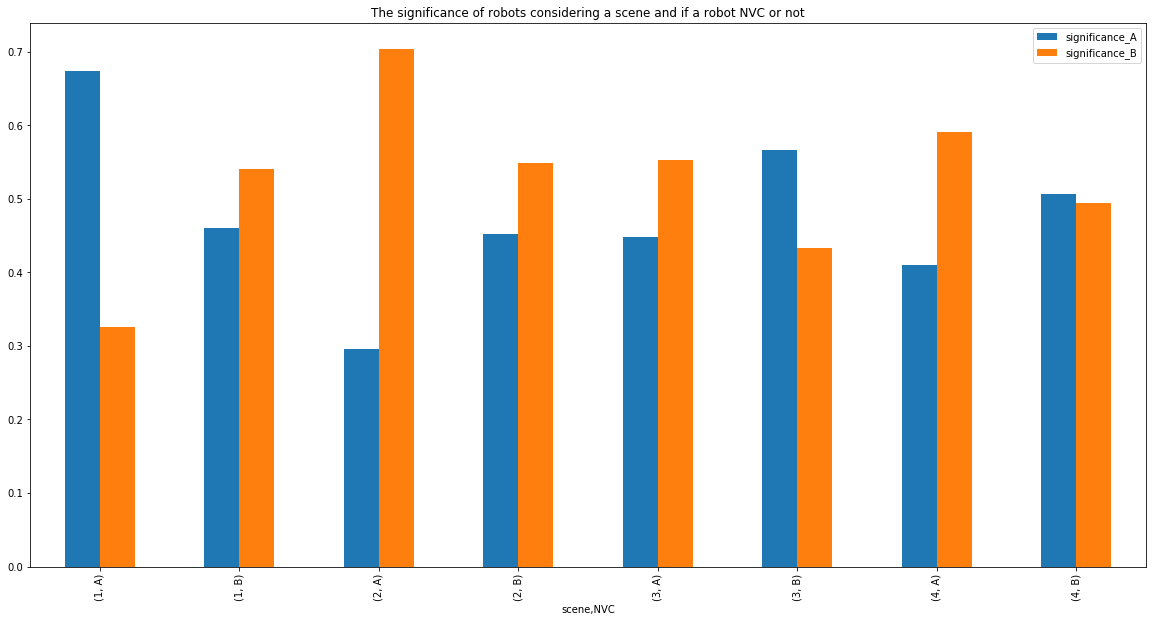

In [0]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene and if a robot NVC or not')

**Questtionnaire Evaluation**
---

# Data Segments Preparation

In [0]:
df = df.drop(columns=['Response ID', 'Date submitted', 'Last page', 'Start language'])
basics = df.loc[ : , ['What is your sex?','How old are you?']]
robot_interaction  = df.loc[ : , [
                      'How familiar are you with computers?', 
                      'Have you ever interacted with a robot before? [Never]',
                      'Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)]',
                      'Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]',
                      'Have you ever interacted with a robot before? [At work (i.e. robotics research)]',
                      'Do you like robots?'
                      ]
                  ]
tipi = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Do you worry a lot?]',
                      'Do you agree or disagree with the following statements? [Do you get nervous easily?]',
                      'Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]',
                      'Do you agree or disagree with the following statements? [Are you talkative?]',
                      'Do you agree or disagree with the following statements? [Are you outgoing, sociable?]',
                      'Do you agree or disagree with the following statements? [Are you reserved?]',
                      'Do you agree or disagree with the following statements? [Are you original? / Do you come up with new ideas?]',
                      'Do you agree or disagree with the following statements? [Do you value artistic, aesthetic experiences?]',
                      'Do you agree or disagree with the following statements? [Do you have an active imagination?]',
                      'Do you agree or disagree with the following statements? [Are you sometimes rude to others?]',
                      'Do you agree or disagree with the following statements? [Do you have a forgiving nature?]',
                      'Do you agree or disagree with the following statements? [Are you considerate and kind to almost everyone?]',
                      'Do you agree or disagree with the following statements? [Do you do a thorough job?]',
                      'Do you agree or disagree with the following statements? [Do you tend to be lazy?]',
                      'Do you agree or disagree with the following statements? [Do you do things efficiently?]',
                      ]
                ]
risk_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Safety first]', 
                      'Do you agree or disagree with the following statements? [I do not take risks with my health]',
                      'Do you agree or disagree with the following statements? [I prefer to avoid risks]',
                      'Do you agree or disagree with the following statements? [I take risks regularly]',
                      'Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]',
                      ]
                  ]
trust_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [One should be very cautious with strangers.]',
                      'Do you agree or disagree with the following statements? [Most experts tell the truth about the limits of their knowledge.]',
                      'Do you agree or disagree with the following statements? [Most people can be counted on to do what they say they will do.]',
                      'Do you agree or disagree with the following statements? [Most people answer public opinion polls honestly.]',
                      ]
                  ]
# post questionaire
godspeed = df.iloc[:,36:111]
openQ = df.iloc[:,111:113]

# Data Preprocessing

In [0]:
# risk propensity
# paper says 1-4 are inverted, but 1-3 and 5 makes more sense...
inverted_keys = [
                   "Do you agree or disagree with the following statements? [Safety first]",
                   "Do you agree or disagree with the following statements? [I do not take risks with my health]",
                   "Do you agree or disagree with the following statements? [I prefer to avoid risks]",
                   "Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]"
]
for key, values in risk_propensity.items():
  print(key)
  if key not in inverted_keys:
    # normal scale
    converted_values = [int(value[1:]) for value in values]
  else:
    # inverted scales
    converted_values = [8-int(value[1:]) for value in values]
  print(converted_values)
  risk_propensity[key] = converted_values
risk_propensity_scores = np.sum(risk_propensity.values, axis=1) / 5.0

Do you agree or disagree with the following statements? [Safety first]
[3, 4, 3, 1, 5, 3, 1, 2, 2, 4, 3, 6]
Do you agree or disagree with the following statements? [I do not take risks with my health]
[5, 4, 1, 1, 4, 2, 2, 1, 3, 4, 3, 5]
Do you agree or disagree with the following statements? [I prefer to avoid risks]
[5, 4, 2, 1, 5, 5, 4, 6, 2, 3, 6, 4]
Do you agree or disagree with the following statements? [I take risks regularly]
[3, 4, 3, 3, 5, 3, 4, 7, 3, 3, 5, 2]
Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]
[4, 3, 4, 1, 6, 3, 4, 3, 3, 3, 4, 1]


In [0]:
rps_mean = np.mean(risk_propensity_scores)
rps_std = np.std(risk_propensity_scores)
print("rps mean {} (scaled: {})".format(rps_mean, rps_mean / 7.0 * 9.0,))
print("rps std {} (scaled: {})".format(rps_std, rps_std / 7.0 * 9.0,))

rps mean 3.383333333333334 (scaled: 4.350000000000001)
rps std 0.8849042634972188 (scaled: 1.1377340530678528)


In [0]:
tipi.replace(to_replace="A1", value=1, inplace=True)
tipi.replace(to_replace="A2", value=2, inplace=True)
tipi.replace(to_replace="A3", value=3, inplace=True)
tipi.replace(to_replace="A4", value=4, inplace=True)
tipi.replace(to_replace="A5", value=5, inplace=True)
tipi.replace(to_replace="A6", value=6, inplace=True)
tipi.replace(to_replace="A7", value=7, inplace=True)

trust_propensity.replace(to_replace="A1", value=1, inplace=True)
trust_propensity.replace(to_replace="A2", value=2, inplace=True)
trust_propensity.replace(to_replace="A3", value=3, inplace=True)
trust_propensity.replace(to_replace="A4", value=4, inplace=True)
trust_propensity.replace(to_replace="A5", value=5, inplace=True)

# Descriptions of data

Age mean:  25.583333333333332


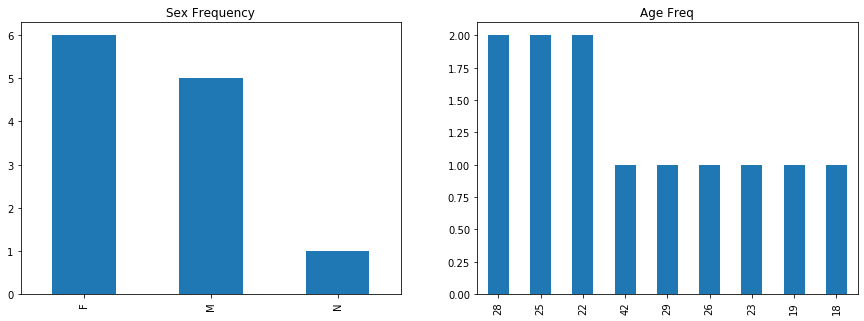

,What is your sex?,How old are you?
0,F,25
1,F,25
2,F,22
3,F,18
4,M,19
5,M,28
6,M,23
7,N,26
8,F,28
9,M,22


In [0]:
print('Age mean: ', np.mean(basics['How old are you?']))
basics['What is your sex?'].replace('A1','F',True)
basics['What is your sex?'].replace('A2','M',True)
basics['What is your sex?'].replace('A3','I',True)
basics['What is your sex?'].replace('A4','N',True)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
basics['What is your sex?'].value_counts().plot(ax=ax[0],kind='bar', title="Sex Frequency")
basics['How old are you?'].value_counts().plot(ax=ax[1],kind='bar', title="Age Freq")
plt.show()
basics

In [0]:
robot_interaction

,How familiar are you with computers?,Have you ever interacted with a robot before? [Never],Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)],"Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]",Have you ever interacted with a robot before? [At work (i.e. robotics research)],Do you like robots?
0,2,NaN,NaN,Y,NaN,A1
1,4,Y,NaN,NaN,NaN,A3
2,5,NaN,Y,NaN,NaN,A1
3,2,Y,NaN,NaN,NaN,A1
4,3,NaN,Y,Y,NaN,A1
5,4,Y,NaN,NaN,NaN,A1
6,5,NaN,Y,NaN,NaN,A3
7,5,NaN,NaN,Y,NaN,A1
8,5,NaN,NaN,NaN,Y,A1
9,4,Y,NaN,NaN,NaN,A1


In [0]:
godspeed.describe()

,"Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Fake – Natural]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Machinelike – Humanlike]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unconscious – Conscious]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Artificial – Lifelike]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Moving rigidly – Moving elegantly]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Dead – Alive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Stagnant – Lively]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Mechanical – Organic]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Inert – Interactive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Apathetic – Responsive]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Dislike – Like]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unfriendly – Friendly]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unkind – Kind]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unpleasant – Pleasant]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Awful – Nice]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Incompetent – Competent]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Ignorant – Knowledgeable]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Irresponsible – Responsible]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Unintelligent – Intelligent]","Please rate the following attributes for robot 732-A (right). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural'. [Foolish - Sensible]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural. [Fake – Natural]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' corresponds to 'Fake' and '9' corresponds to 'Natural. [Machinelike – Humanlike]","Please rate the following attributes now for robot 732-B (left). For example, in the first row '1' 

In [0]:
risk_propensity

,Do you agree or disagree with the following statements? [Safety first],Do you agree or disagree with the following statements? [I do not take risks with my health],Do you agree or disagree with the following statements? [I prefer to avoid risks],Do you agree or disagree with the following statements? [I take risks regularly],Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]
0,3,5,5,3,4
1,4,4,4,4,3
2,3,1,2,3,4
3,1,1,1,3,1
4,5,4,5,5,6
5,3,2,5,3,3
6,1,2,4,4,4
7,2,1,6,7,3
8,2,3,2,3,3
9,4,4,3,3,3


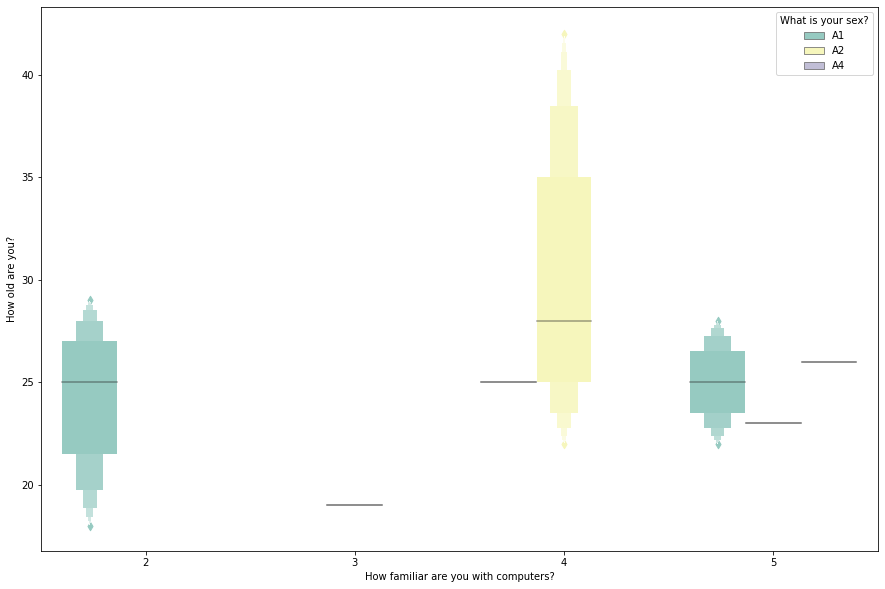

In [0]:
plt.figure(figsize=(15,10))
sns.boxenplot(df["How familiar are you with computers?"], df["How old are you?"] , hue=df["What is your sex?"], palette="Set3")
plt.show()

In [0]:
robot_interaction['fam_binary'] = 1
robot_interaction.loc[robot_interaction['Have you ever interacted with a robot before? [Never]'] == 'Yes', 'fam_binary'] = 0
robot_interaction

,How familiar are you with computers?,Have you ever interacted with a robot before? [Never],Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)],"Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]",Have you ever interacted with a robot before? [At work (i.e. robotics research)],Do you like robots?,fam_binary
0,2,NaN,NaN,Y,NaN,A1,1
1,4,Y,NaN,NaN,NaN,A3,1
2,5,NaN,Y,NaN,NaN,A1,1
3,2,Y,NaN,NaN,NaN,A1,1
4,3,NaN,Y,Y,NaN,A1,1
5,4,Y,NaN,NaN,NaN,A1,1
6,5,NaN,Y,NaN,NaN,A3,1
7,5,NaN,NaN,Y,NaN,A1,1
8,5,NaN,NaN,NaN,Y,A1,1
9,4,Y,NaN,NaN,NaN,A1,1


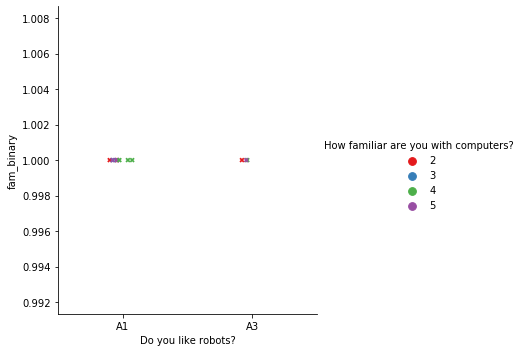

In [0]:
sns.catplot(x='Do you like robots?', y= "fam_binary", hue='How familiar are you with computers?', data=robot_interaction, palette="Set1", marker='X', kind="strip")
plt.show()

In [0]:
df2 = pd.DataFrame({'id': [1,2,3,4,5,6,7,8], 
                  's2_wrt_nvc': [-1,0,0,0,2,-2,2,-7]})
df2.describe()

,id,s2_wrt_nvc
count,8.00000,8.000000
mean,4.50000,-0.750000
std,2.44949,2.866058
min,1.00000,-7.000000
25%,2.75000,-1.250000
50%,4.50000,0.000000
75%,6.25000,0.500000
max,8.00000,2.000000


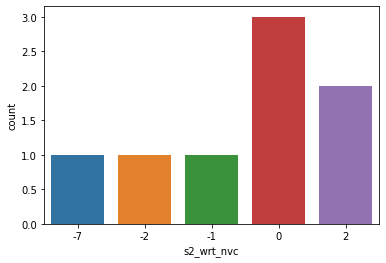

In [0]:
sns.countplot(x="s2_wrt_nvc", data=df2)
plt.show()

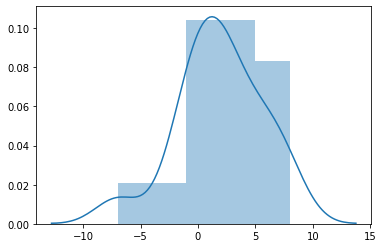

In [0]:
sns.distplot(df2)
plt.show()

In [0]:
df3 = pd.DataFrame({'id': [1,2,3,4,5,6,7,8], 
                    's0A': [0,1,2,2,1,1,2,1],
                    's0B' :[1,1,2,2,2,1,2,1],
                    's1A': [1,2,1,0,3,0,1,4],
                    's1B': [1,2,2,2,2,0,3,0],
                    's2A': [3,2,3,2,1,1,2,0],
                    's2B': [2,2,3,2,3,3,4,7],
                    's3A': [3,0,4,3,4,0,4,3],
                    's3B': [3,3,3,3,3,7,3,2],
                    's4A': [3,4,4,2,2,0,0,3],
                    's4B': [3,2,3,2,5,7,7,3],
                    'AB':['B','A','B','A','B','A','B','A']})
df3

,id,s0A,s0B,s1A,s1B,s2A,s2B,s3A,s3B,s4A,s4B,AB
0,1,0,1,1,1,3,2,3,3,3,3,B
1,2,1,1,2,2,2,2,0,3,4,2,A
2,3,2,2,1,2,3,3,4,3,4,3,B
3,4,2,2,0,2,2,2,3,3,2,2,A
4,5,1,2,3,2,1,3,4,3,2,5,B
5,6,1,1,0,0,1,3,0,7,0,7,A
6,7,2,2,1,3,2,4,4,3,0,7,B
7,8,1,1,4,0,0,7,3,2,3,3,A


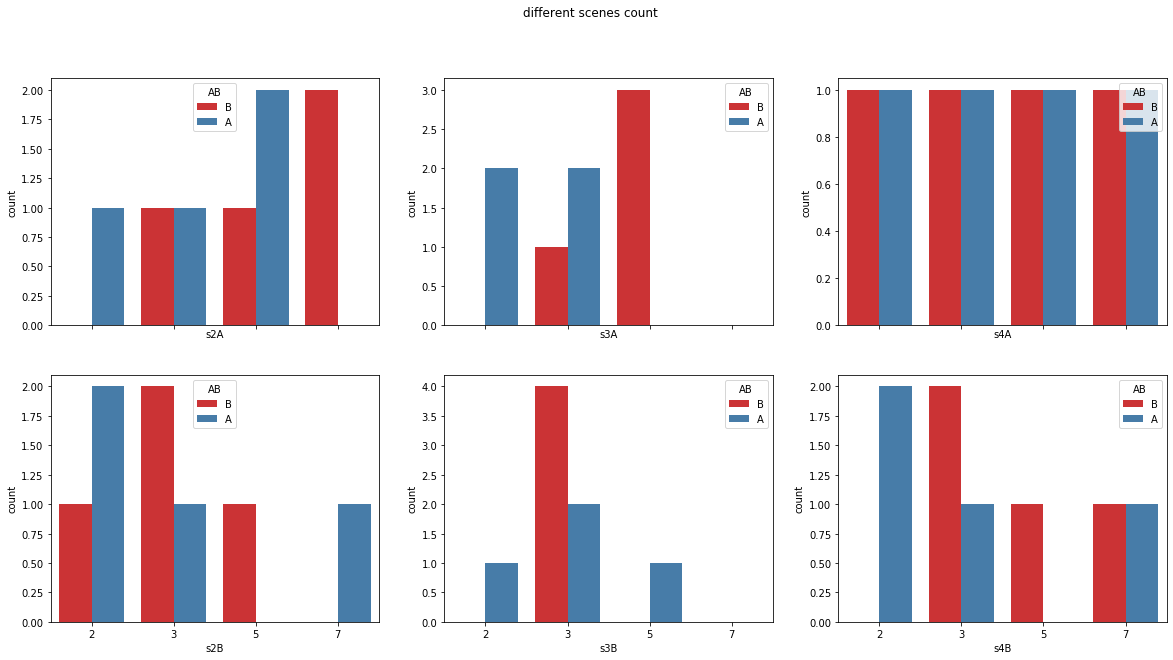

In [0]:
#sns.pairplot(hue='AB', data=df3, palette="Set1")
#plt.show()
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,10),sharex=True)
fig.suptitle('different scenes count')
#fig.tight_layout()
sns.countplot(x='s2A', data=df3, ax=axs[0,0], hue='AB', palette="Set1")
sns.countplot(x='s2B', data=df3, ax=axs[1,0], hue='AB', palette="Set1")
sns.countplot(x='s3A', data=df3, ax=axs[0,1], hue='AB', palette="Set1")
sns.countplot(x='s3B', data=df3, ax=axs[1,1], hue='AB', palette="Set1")
sns.countplot(x='s4A', data=df3, ax=axs[0,2], hue='AB', palette="Set1")
sns.countplot(x='s4B', data=df3, ax=axs[1,2], hue='AB', palette="Set1")

plt.show()

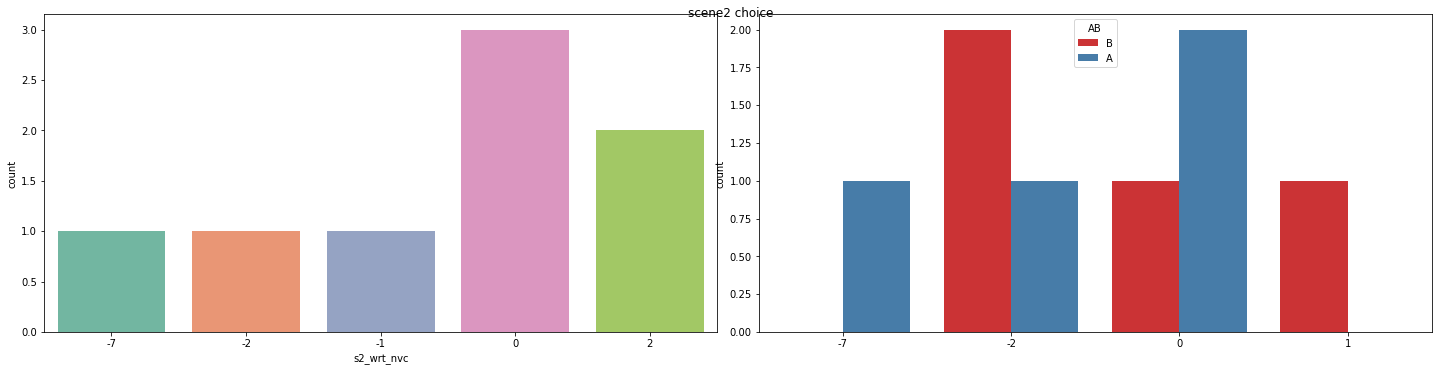

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('scene2 choice')
fig.tight_layout()
sns.countplot(x=df2['s2_wrt_nvc'], ax=axs[0], palette='Set2')
sns.countplot(df3['s2A']-df3['s2B'], ax=axs[1], hue=df3['AB'], palette='Set1')
plt.show()

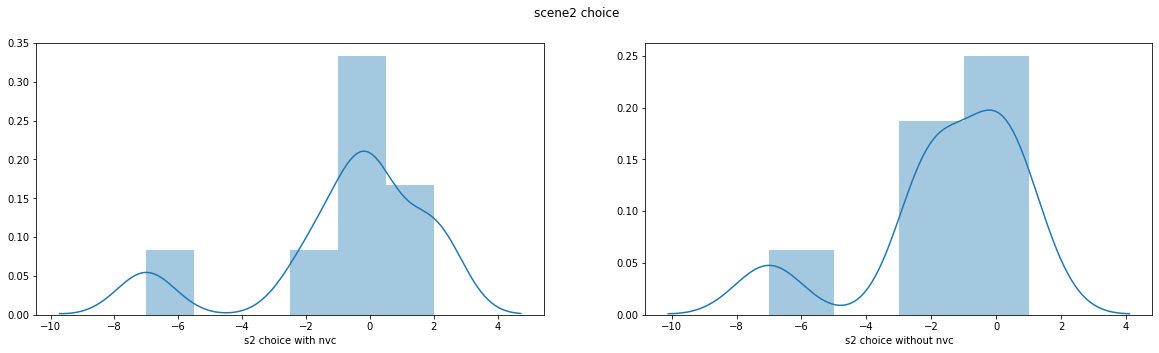

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('scene2 choice')
sns.distplot(df2['s2_wrt_nvc'], ax=axs[0], axlabel="s2 choice with nvc")
sns.distplot(df3['s2A']-df3['s2B'], ax=axs[1], axlabel="s2 choice without nvc")
plt.show()

                           Scene 2 choice categorized


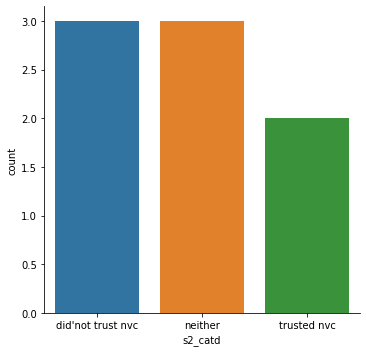

In [0]:
#df2['s2_wrt_nvc']
print("                           Scene 2 choice categorized")
df2['s2_catd'] = "neither"
df2.loc[df2['s2_wrt_nvc'] > 0, 's2_catd'] = "trusted nvc"
df2.loc[df2['s2_wrt_nvc'] < 0, 's2_catd'] = "did'not trust nvc"
sns.catplot(data=df2, x = 's2_catd',  kind="count")
plt.show()

No idea what this is


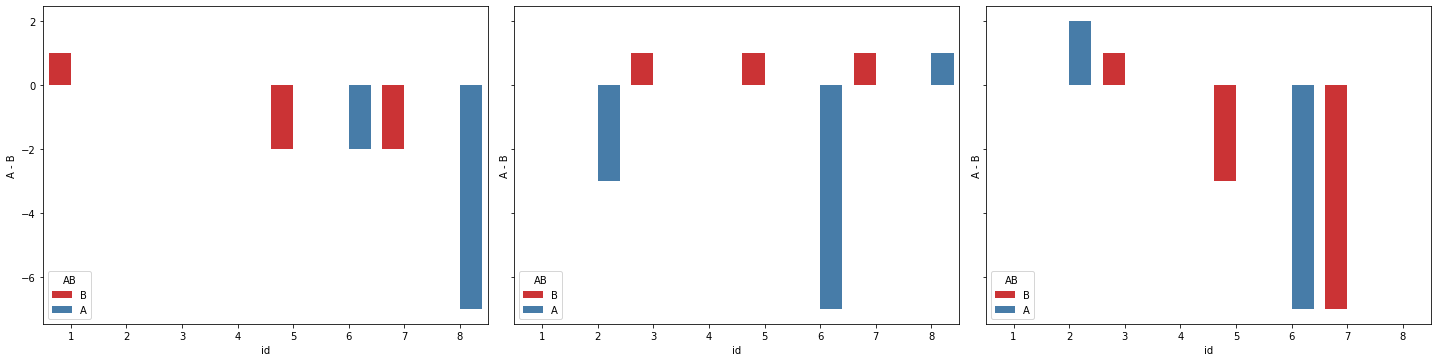

In [0]:
print('No idea what this is')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5), sharey=True)
fig.tight_layout()
axs[0].set_xlabel("participant number")
axs[0].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s2A']-df3['s2B'], ax=axs[0], hue=df3['AB'], palette="Set1")
axs[1].set_xlabel("participant number")
axs[1].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s3A']-df3['s3B'], ax=axs[1], hue=df3['AB'], palette="Set1")
axs[2].set_xlabel("participant number")
axs[2].set_ylabel("A - B")
sns.barplot(x=df3['id'], y=df3['s4A']-df3['s4B'], ax=axs[2], hue=df3['AB'], palette="Set1")
plt.show()